Mounted at /content/drive
Number of image files: 7


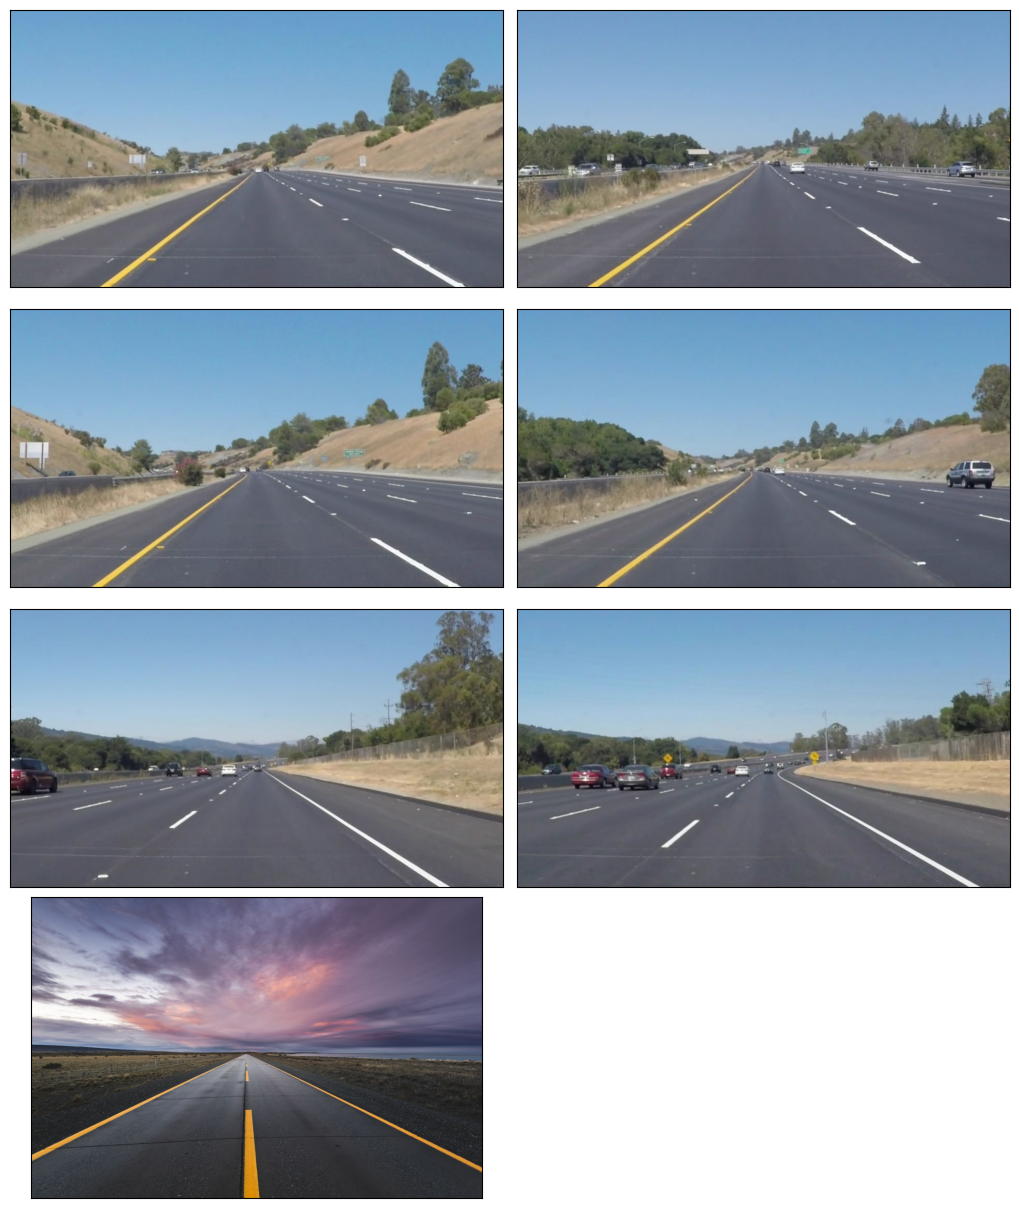

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from IPython.display import Image, display
from google.colab import drive
drive.mount('/content/drive')
# Specify the path to the test images directory in Google Drive
test_images_path = '/content/drive/MyDrive/images/*'

# Read and load images from the test_images directory
input_images = [mpimg.imread(img_path) for img_path in glob.glob(test_images_path)]
print(f"Number of image files: {len(input_images)}")

# Iterate through each image file
def show_images(images, cols, title='Default'):
    cmap = None
    columns = cols
    rows = (len(images)+1)//cols

    plt.figure(figsize=(10,12))
    for i,image in enumerate(images):
        plt.subplot(rows,columns, i+1)
        if len(image.shape) == 2:
            cmap = 'gray'
        plt.subplot(rows,cols,i+1)
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=1)
    plt.show()

show_images(input_images, cols=2, title='Inputimages')

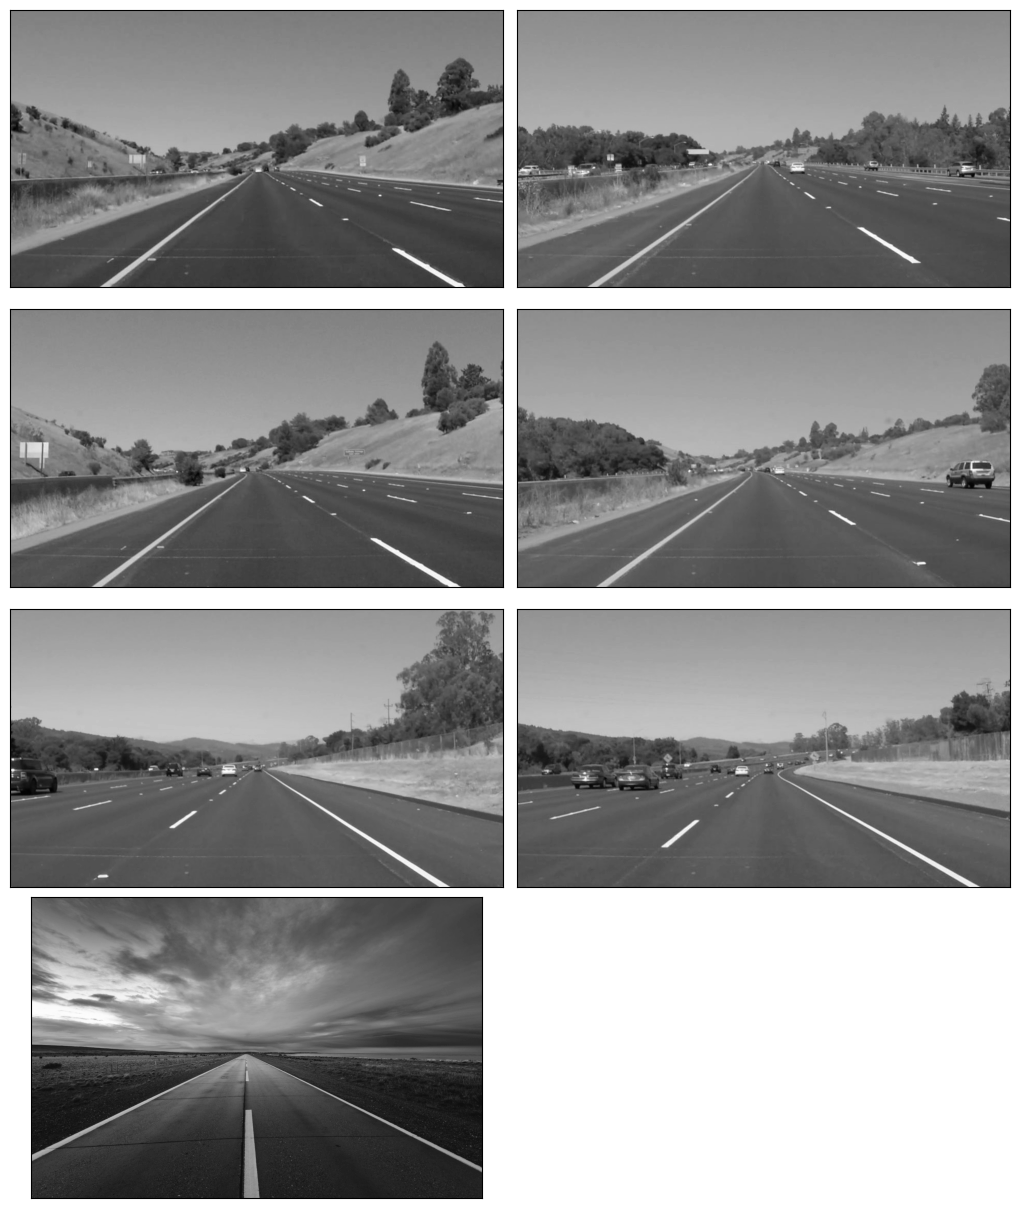

In [2]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

gray_scale_images = list(map(grayscale, input_images))
show_images(gray_scale_images, cols=2, title='grayscale_images')

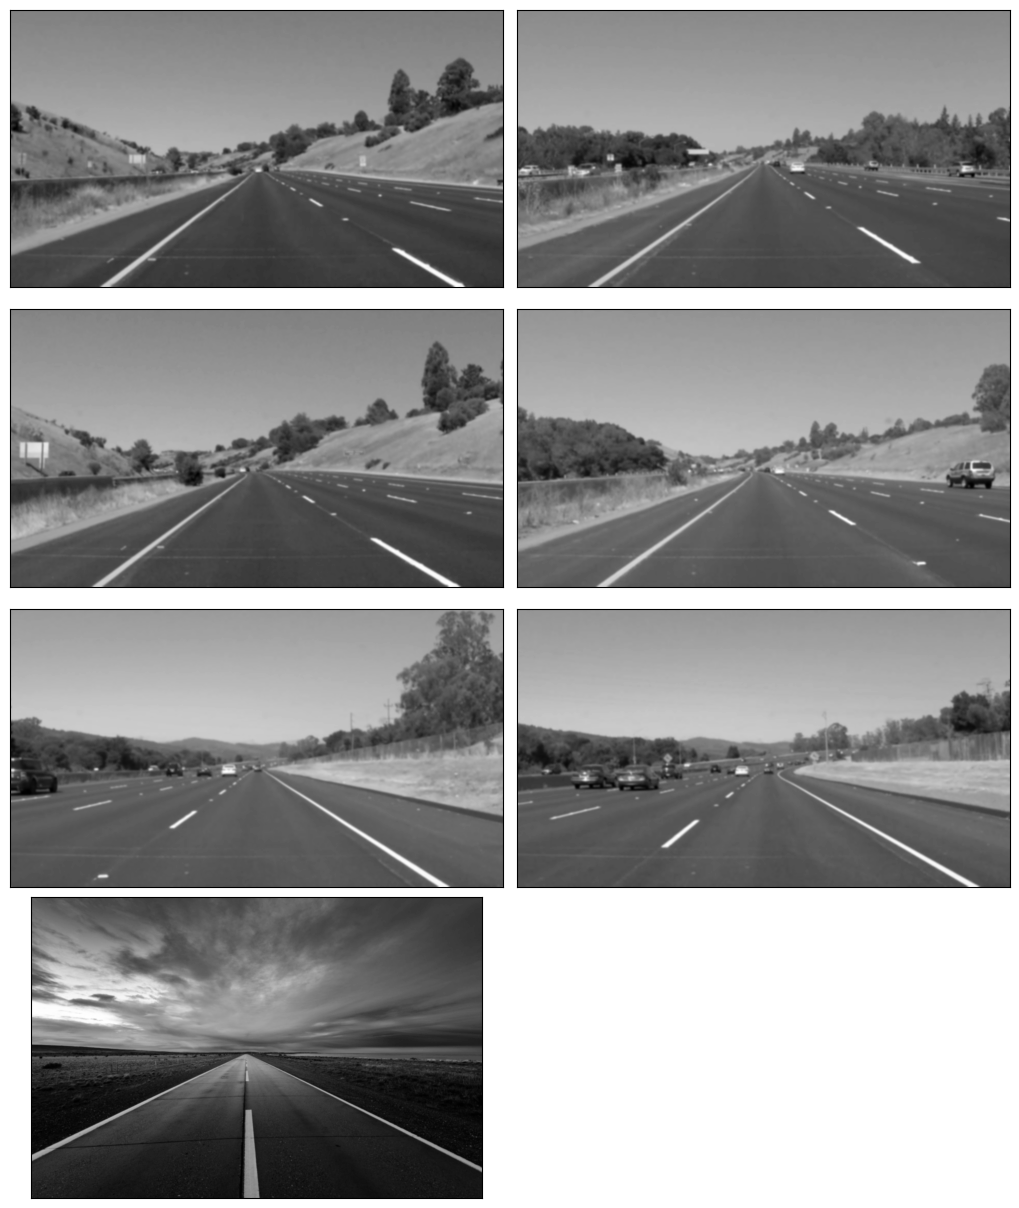

In [3]:
def gaussian(img, kernel_size=7):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

gussian_img = list(map(gaussian, gray_scale_images))
show_images(gussian_img, cols = 2, title='Gaussian')

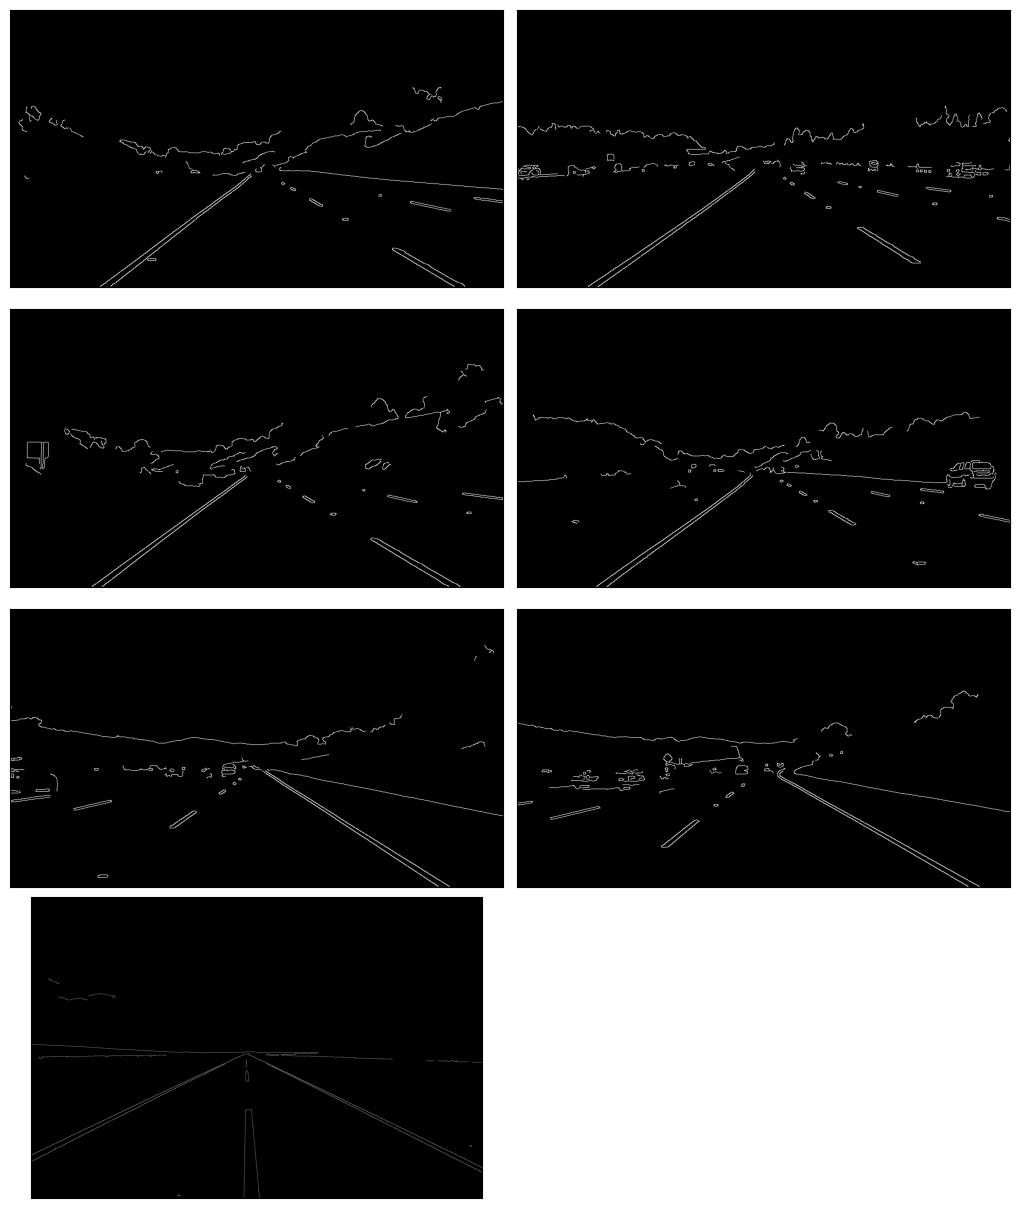

In [4]:
def CannyEdgeDetection(img, low_threshold = 75, high_threshold = 175):

    return cv2.Canny(img, low_threshold, high_threshold)


edge_detection = list(map(CannyEdgeDetection, gussian_img))

show_images(edge_detection, cols =2, title = 'Canny_Edge_Detection_image')

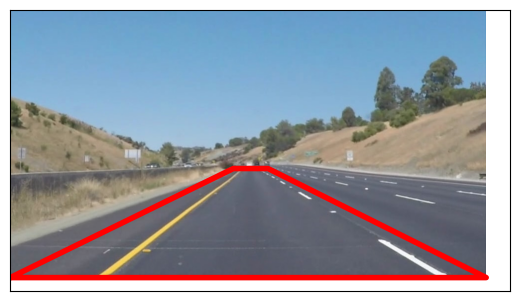

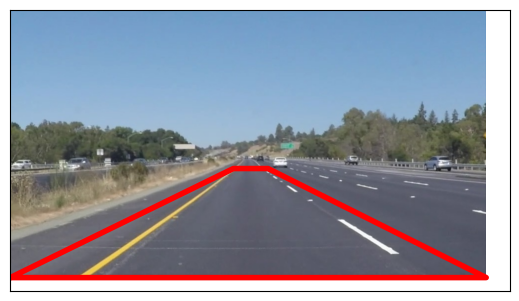

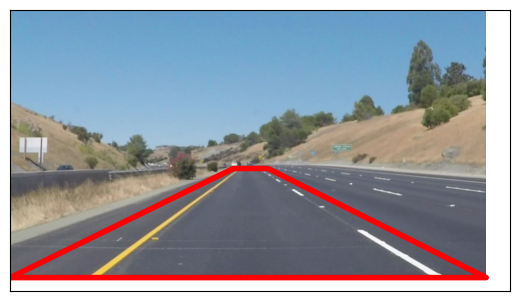

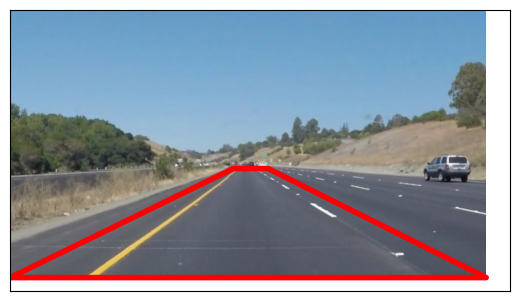

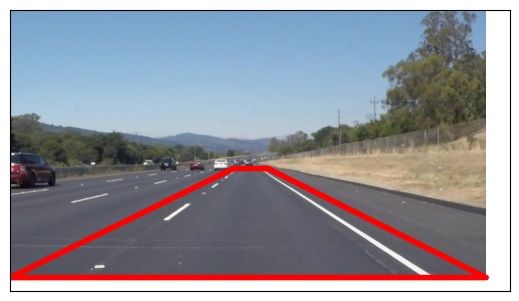

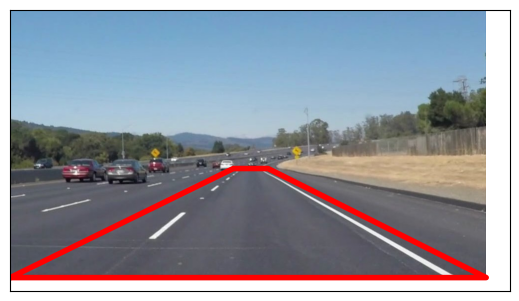

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def visualise_region(image):
    """
    Function takes a colour image and then gives various regional
    visulisations
    """
    dims = image.shape
    colour_select = np.copy(image)
    line_select = np.copy(image)

    #Define cordinates for region
    left_bottom = [0, dims[0]]
    left_top = [450, 320]
    right_top = [520, 320]
    right_bottom = [dims[1], dims[0]]

    #Plot the two region images side by side
    plt.figure(figsize=(10,12))
    #left
    plt.subplot(1,2,1)
    plt.imshow(image)
    x = [left_bottom[0], right_bottom[0], right_top[0], left_top[0] ,left_bottom[0]]
    y = [left_bottom[1], right_bottom[1], right_top[1], left_top[1] ,left_bottom[1]]
    plt.plot(x, y, 'r-', lw=4)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def region_selection(image):


    dims = image.shape
    #Define vertices for the region of intrest
    vertices = np.array([[(0,dims[0]),(450, 320),(520, 320),(dims[1], dims[0])]], dtype=np.int32)

    return region_of_interest(image, vertices)

ROI_edge_detection = list(map(region_selection, edge_detection))

visualise_region(input_images[0])
visualise_region(input_images[1])
visualise_region(input_images[2])
visualise_region(input_images[3])
visualise_region(input_images[4])
visualise_region(input_images[5])


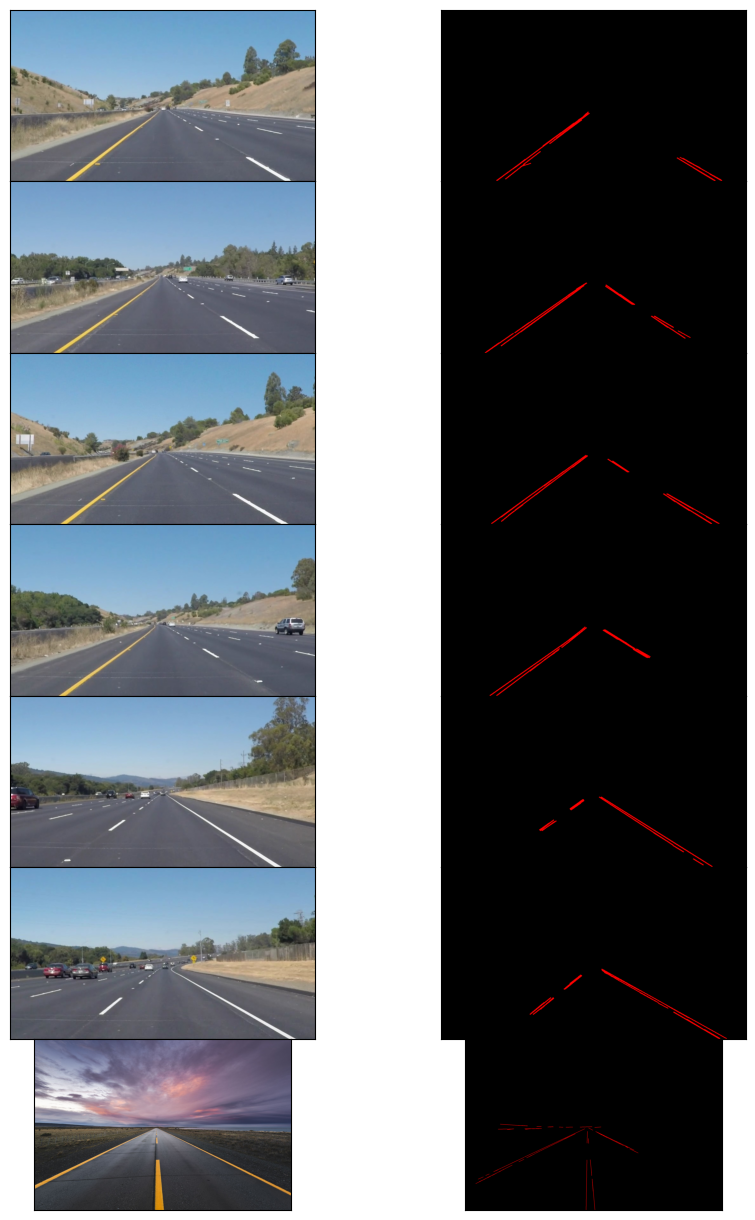

In [9]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_basic(img, rho=4, theta=np.pi/180, threshold=20, min_line_len=30, max_line_gap=25):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

raw_hough_image = list(map(hough_lines_basic, ROI_edge_detection))

print_items = []
print_items.append(input_images[0])
print_items.append(raw_hough_image[0])
print_items.append(input_images[1])
print_items.append(raw_hough_image[1])
print_items.append(input_images[2])
print_items.append(raw_hough_image[2])
print_items.append(input_images[3])
print_items.append(raw_hough_image[3])
print_items.append(input_images[4])
print_items.append(raw_hough_image[4])
print_items.append(input_images[5])
print_items.append(raw_hough_image[5])
print_items.append(input_images[6])
print_items.append(raw_hough_image[6])
show_images(print_items, cols=2, title='hough_tranform' )

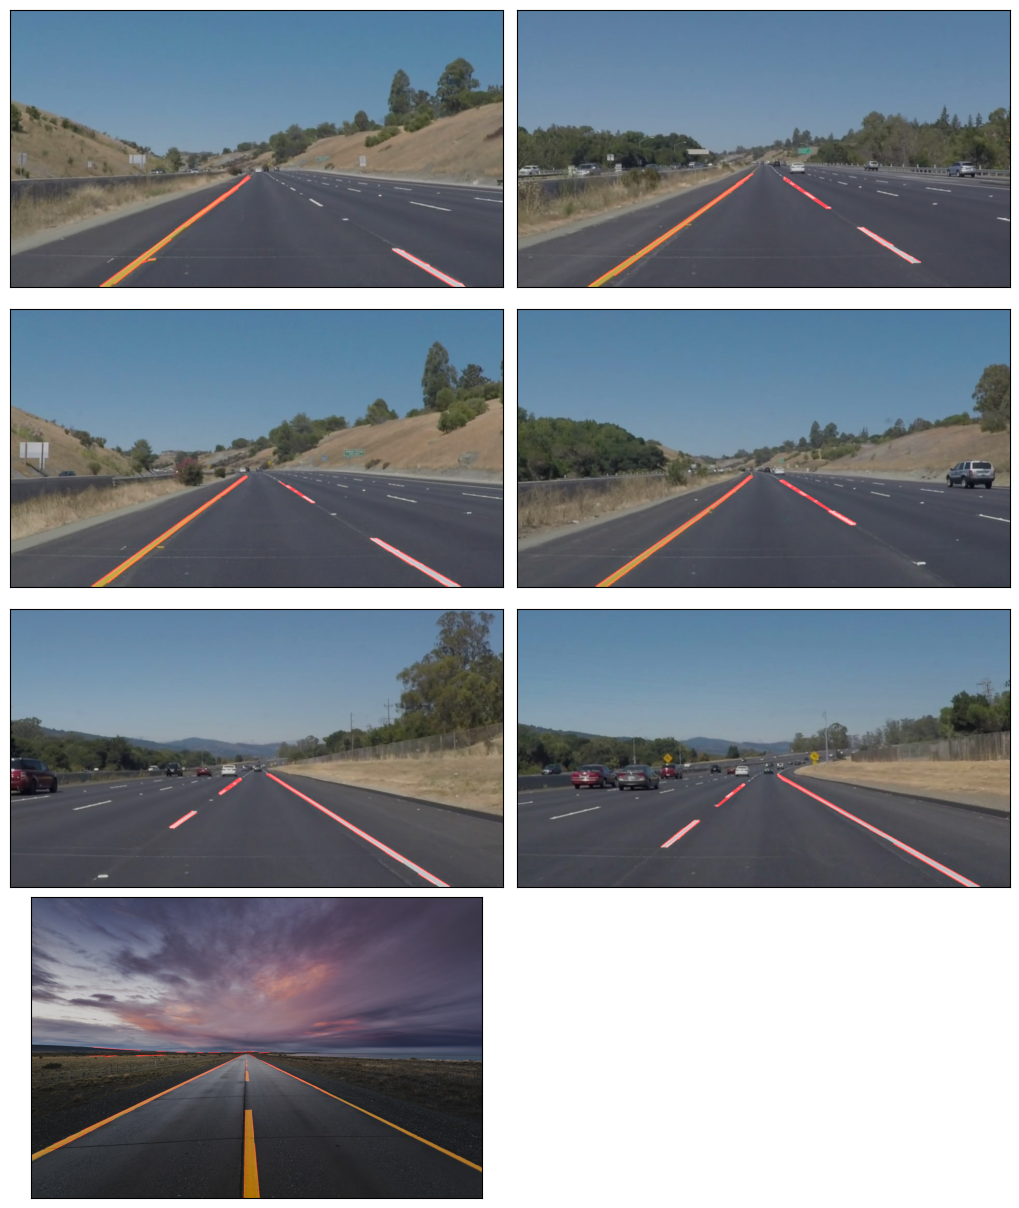

In [11]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def lane_line_process(image, image2):
    final_result = weighted_img(image2, image)

    return final_result

#Apply the lane finding pipeline
detected_lanes = list(map(lane_line_process, input_images, raw_hough_image))

show_images(detected_lanes, cols = 2, title='Basic_pipeline')